## Bonus: Attention Lens Challenge

1. Importing necessary libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from IPython import get_ipython
from IPython.display import display
import os

2. Loading Tokenizer and Sequences

In [16]:
with open('eng_tokenizer.pkl', 'rb') as f:
    eng_tokenizer = pickle.load(f)

with open('fra_tokenizer.pkl', 'rb') as f:
    fra_tokenizer = pickle.load(f)

In [17]:
data = np.load('data.npz', allow_pickle=True)
encoder_input_data = np.array(data['encoder_input_data'], dtype=np.int32)
decoder_input_data = np.array(data['decoder_input_data'], dtype=np.int32)

3. Helper Decoding Function

In [18]:
def decode_sequence(seq, tokenizer, eos_token='<eos>'):
    result = []
    eos_id = tokenizer.word_index.get(eos_token)
    for token_id in seq:
        if token_id == 0 or (eos_id and token_id == eos_id):
            break
        result.append(tokenizer.index_word.get(token_id, '<?>'))
    return result

4. Attention Extractor

In [19]:
class AttentionExtractorModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        try:
            self.encoder_embedding = model.get_layer("encoder_embedding")
            self.encoder_lstm = model.get_layer(index=3)
            self.decoder_embedding = model.get_layer("decoder_embedding")
            self.decoder_lstm = model.get_layer("decoder_lstm")
            self.attention = model.get_layer("attention_layer")
            self.output_dense = model.get_layer("output_dense")

        except ValueError as e:
            print(f"Error retrieving layer: {e}")
            print("Please check the layer names or indices in your loaded model.")
            raise e


    def call(self, encoder_input, decoder_input):
        enc_embed = self.encoder_embedding(encoder_input)
        try:
             enc_outputs, fh, fc, bh, bc = self.encoder_lstm(enc_embed)
        except Exception as e:
             print(f"Error calling encoder_lstm in AttentionExtractorModel.call: {e}")
             print(f"Input shape to encoder_lstm: {enc_embed.shape}")
             print(f"Expected output shape/structure from encoder_lstm: 5 tensors (outputs, fh, fc, bh, bc)")
             raise e
        encoder_states = [tf.concat([fh, bh], axis=-1), tf.concat([fc, bc], axis=-1)]

        dec_embed = self.decoder_embedding(decoder_input)
        try:
            dec_outputs, _, _ = self.decoder_lstm(dec_embed, initial_state=encoder_states)
        except Exception as e:
             print(f"Error calling decoder_lstm in AttentionExtractorModel.call: {e}")
             print(f"Input shape to decoder_lstm: {dec_embed.shape}")
             print(f"Initial state shapes to decoder_lstm: {[s.shape for s in encoder_states]}")
             print(f"Expected output shape/structure from decoder_lstm: 3 tensors (outputs, final_h, final_c)")
             raise e
        try:
            context_vector, attn_scores = self.attention(
                [dec_outputs, enc_outputs], return_attention_scores=True
            )
        except Exception as e:
             print(f"Error calling attention layer in AttentionExtractorModel.call: {e}")
             print(f"Input shapes to attention layer: Queries={dec_outputs.shape}, Keys={enc_outputs.shape}")
             print("Check if the attention layer accepts [queries, keys] and return_attention_scores=True.")
             raise e
        combined = tf.concat([dec_outputs, context_vector], axis=-1)
        try:
             final_output = self.output_dense(combined)
        except Exception as e:
             print(f"Error calling output_dense layer in AttentionExtractorModel.call: {e}")
             print(f"Input shape to output_dense layer: {combined.shape}")
             raise e
        return final_output, attn_scores, enc_outputs

5. Loading Model saved in part 2

In [20]:
try:
    base_model = tf.keras.models.load_model("best_model_part2_attention.h5", compile=False)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_model_part2_attention.h5' is in the correct directory.")

Model loaded successfully.


In [21]:
try:
    attn_model = AttentionExtractorModel(base_model)
    print("AttentionExtractorModel instantiated.")
    dummy_enc_input = tf.zeros((1, encoder_input_data.shape[1]), dtype=tf.int32)
    dummy_dec_input = tf.zeros((1, decoder_input_data.shape[1]), dtype=tf.int32)
except Exception as e:
    print(f"Error instantiating AttentionExtractorModel: {e}")
    print("Check the AttentionExtractorModel class __init__ method for layer name/index issues.")

AttentionExtractorModel instantiated.


6. Visualization Function

In [ ]:
def visualize_attention(example_idx, max_len=20):
    src_seq = encoder_input_data[example_idx]
    tgt_seq = decoder_input_data[example_idx]

    enc_input = np.expand_dims(src_seq, axis=0)
    dec_input = np.expand_dims(tgt_seq, axis=0)

    try:
        pred_logits, attn_weights, _ = attn_model(enc_input, dec_input)
        attn_weights = attn_weights.numpy()[0][:max_len, :max_len]

    except Exception as e:
        print(f"Error during attn_model call for example {example_idx}: {e}")
        print("Skipping visualization for this example.")
        return
    src_tokens = decode_sequence(src_seq[:max_len], eng_tokenizer)
    tgt_tokens = decode_sequence(tgt_seq[:max_len], fra_tokenizer)
    attn_weights_display = attn_weights[:len(tgt_tokens), :len(src_tokens)]
    fig, ax = plt.subplots(figsize=(len(src_tokens) * 0.5 + 2, len(tgt_tokens) * 0.5 + 2)) # Adjust figsize dynamically
    cax = ax.matshow(attn_weights_display, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='left') # Rotate and align x-labels
    ax.set_yticklabels(tgt_tokens)
    ax.set_xlabel('English Sentence (Encoder Input)')
    ax.set_ylabel('French Sentence (Decoder Prediction)')
    ax.set_title(f"Attention Map (Example {example_idx})")
    fig.tight_layout()
    plt.show()
    plt.close(fig)

7. Example


Visualizing attention maps:


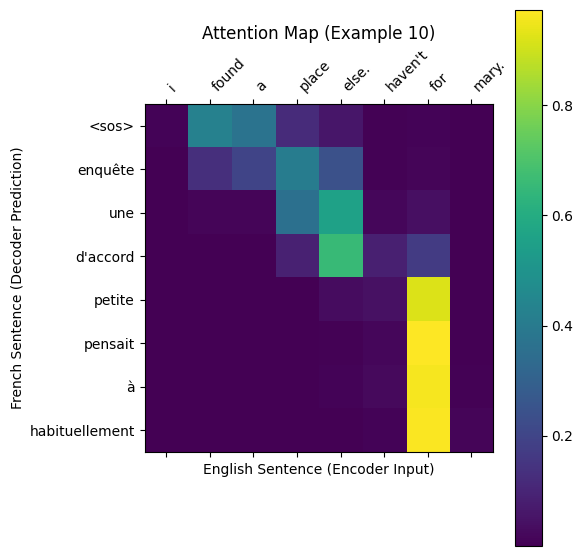

<Figure size 640x480 with 0 Axes>

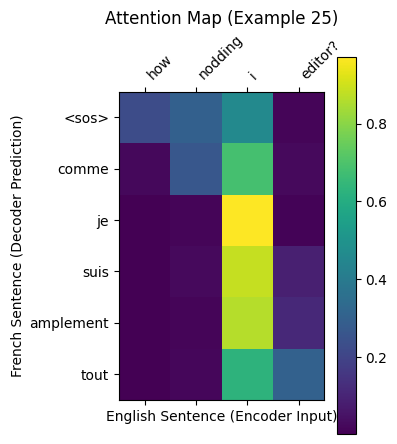

<Figure size 640x480 with 0 Axes>

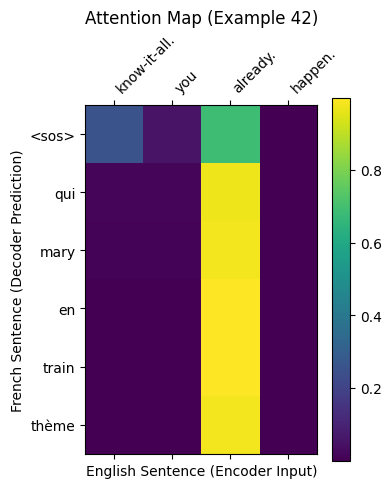

<Figure size 640x480 with 0 Axes>

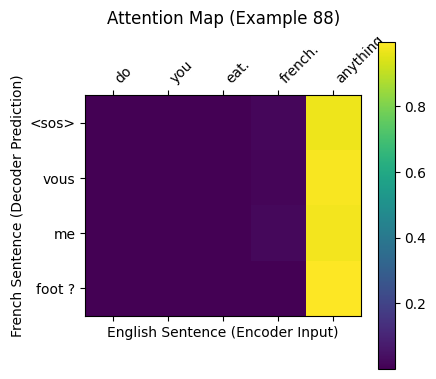

<Figure size 640x480 with 0 Axes>

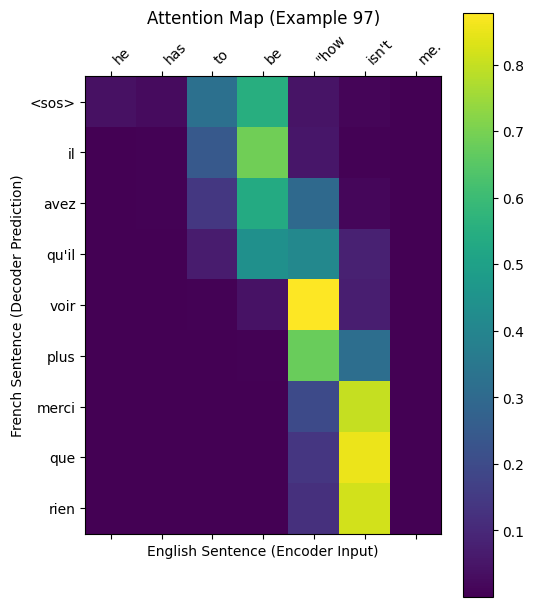

<Figure size 640x480 with 0 Axes>

In [29]:
print("\nVisualizing attention maps:")
for idx in [10, 25, 42, 88, 97]:
    visualize_attention(idx)